# 신경망 학습

In [115]:
# 라이브러리
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import sys
import os

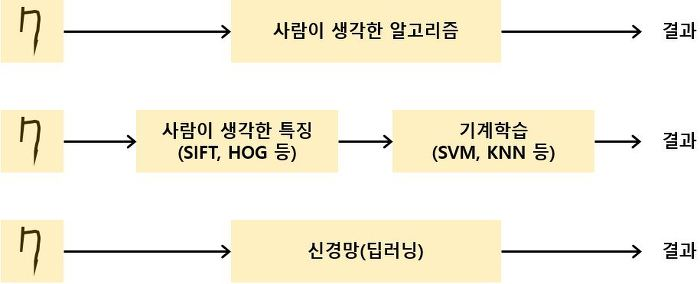

데이터를 이용해 결과를 내는 세 가지 방법

두 번째 방법에서는 접근 방법을 사람이 설정

신경망은 입력 데이터에 어떤 특징이 중요한지도 기계가 학습한다. (가중치를 수정해가면서)

따라서 end-to-end 라고도 한다.

# 손실 함수

In [55]:
# 오차제곱합
def sum_squares_error(y, t): 
    return 0.5 * np.sum((y-t)**2)

# 원 핫 인코딩
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # 정답 2

# 신경망의 출력 2인 경우
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
print(sum_squares_error(np.array(y), np.array(t)))

# 신경망의 출력이 7인 경우
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
print(sum_squares_error(np.array(y), np.array(t)))

0.09750000000000003
0.5975


교차 엔트로피에 로그 이유
https://gooopy.tistory.com/63

In [56]:
# 교차 엔트로피
def cross_entropy_error(y, t):
    delta = 1e-7 # log에 0 이 입력되는 사태 방지
    return -np.sum(t * np.log(y + delta)) 

t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]

print(cross_entropy_error(np.array(y), np.array(t)))

y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]

print(cross_entropy_error(np.array(y), np.array(t)))

0.510825457099338
2.302584092994546


In [57]:
path = '/content/drive/MyDrive/deep-learning-from-scratch-master'
os.chdir(path)
sys.path.append(os.chdir)
from dataset.mnist import load_mnist

# 0.0~1.0 으로 정규화한 데이터로 받아온다.
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# flatten의 default값이 True
print(x_train.shape)
# one_hot_label True
print(t_train.shape, '\n')

(60000, 784)
(60000, 10) 



In [58]:
train_size = x_train.shape[0] # 60000
batch_size = 10 
batch_mask = np.random.choice(train_size, batch_size)
print(batch_mask)

x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

# 10장의 데이터인지 확인
print(x_batch.shape) # (10,784)
print(t_batch.shape) # (10,10)

[30024 11499 44081 45560 47013  1766 52146 30528 37763 46531]
(10, 784)
(10, 10)


In [59]:
# 0 이상 60000 미만의 수 중에서 무작위로 10개 골라낸 것을 반환
print(np.random.choice(60000, 10))

[53821 40039 38142 32192  1563  1392 18832 50324 37324 21924]


In [60]:
# 미니배치를 위한 교차 엔트로피 오차 구현

# Case 1 : 정답 레이블이 원-핫 인코딩인 경우
def cross_entropy_error(y, t):   # y : 신경망 출력, t : 정답 레이블
    if y.ndim == 1:    # y가 1차원이다 => 데이터 하나당 교차 엔트로피 오차를 구한다 의 경우
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    delta = 1e-7
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + delta)) / batch_size

In [61]:
# Case 2 : 정답 레이블이 단순 레이블 형태인 경우
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [62]:
# 단순 레이블(원핫 인코딩 아니고, 2, 7 등)일 때 왜 저렇게 표현할 수 있나?
t = [2, 3]
y = np.array([ [0.1, 0.05, 0.5, 0.1, 0.05, 0.1, 0.0, 0.05, 0.05, 0.0],
               [0.1, 0.0,  0.0, 0.7, 0.0, 0.1, 0.0,  0.05,  0.05, 0.0] ] ) # 2,10

batch_size = y.shape[0] # 2
result = y[np.arange(batch_size), t]
print(result)
result = np.log(y[np.arange(batch_size), t] + 1e-7)
print(result)

[0.5 0.7]
[-0.69314698 -0.3566748 ]


  정확도를 놔두고 '손실함수' 를 사용하는 이유 => 미분
  - 우리 목적은 '높은 정확도'를 끌어내는 매개변수(가중치, 편향)을 찾는거임
  - 미분 값을 근거로 매개변수의 값을 갱신하면서 찾을 수 있음
  - 근데 정확도를 지표로 삼고 미분하면 대부분 장소에서 0 이 되기 떄문에 찾기 힘들다.

# 수치 미분

미분을 구현해보자

아래의 코드는 나쁜 예시다. 이유는:

- h 값이 너무 작아 반올림 오차가 발생한다.

- 전방 차분을 사용한다.

In [63]:
# 나쁜 구현 예
def numerical_diff(f,x):
    h = 10e-50 # 작은 값 넣고 싶어서 10e-50
    return (f(x+h)-f(x) / h)



개선방안:
- h = $10^{-4}$
- 중앙 차분 $\frac{f(x+h)-f(x-h)}{2*h}$

In [64]:
# 개선된 구현
def numerical_diff(f,x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

$y = 0.01x^2 + 0.1x$
에 대해 위의 수치 미분을 사용해보자.

In [65]:
def function_1(x):
    return 0.01*(x**2) + 0.1*x

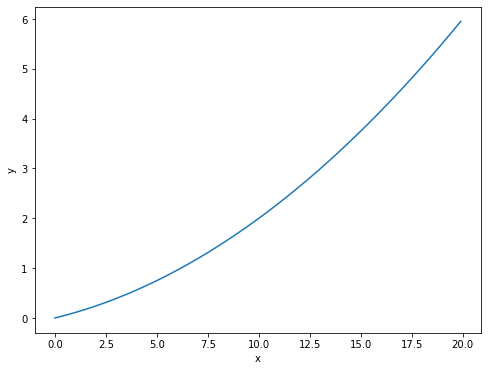

In [66]:
x = np.arange(0,20, 0.1) # 0~19.9
y = function_1(x)

plt.figure(figsize=(8,6))
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x,y)
plt.show()

해석적 해 : $\frac{dy}{dx} = 0.02x + 0.1$

5를 대입하면 0.2, 10을 대입하면 0.3

In [67]:
print(numerical_diff(function_1,5))
print(numerical_diff(function_1,10))

0.1999999999990898
0.2999999999986347


========== x = 5 인 경우 ===========
수치 미분 결과 : 0.1999999999990898
========== x = 10 인 경우 ==========
수치 미분 결과 : 0.2999999999986347


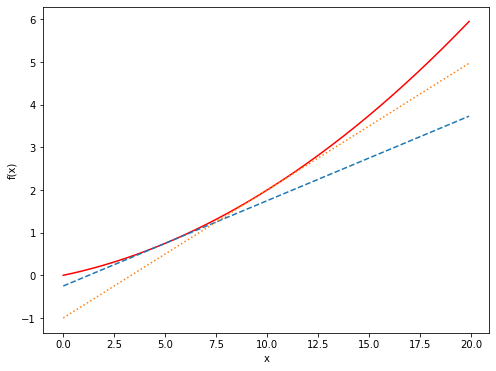

In [93]:
# 수치미분 결과를 기울기로하는 직선 그리기
def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(f'수치 미분 결과 : {d}')
    y = f(x) - d*x
    return lambda t: d*t + y
     
x = np.arange(0.0, 20.0, 0.1) # 0~19.9
y = function_1(x)
print('========== x = 5 인 경우 ===========')
tf = tangent_line(function_1, 5)
y2 = tf(x)
print('========== x = 10 인 경우 ==========')
tf = tangent_line(function_1, 10)
y3 = tf(x)
print('===================================')
plt.figure(figsize=(8,6))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y, 'r')
plt.plot(x, y2,'--')
plt.plot(x, y3,':')
plt.show()

편미분 

$f(x_0,x_1) = {x_0}^2 + {x_1}^2$

In [123]:
# 행렬로 표현 가능, 구현
def function_2(x):
    #return x[0]**2 + x[1]**2
    return np.sum(x**2)

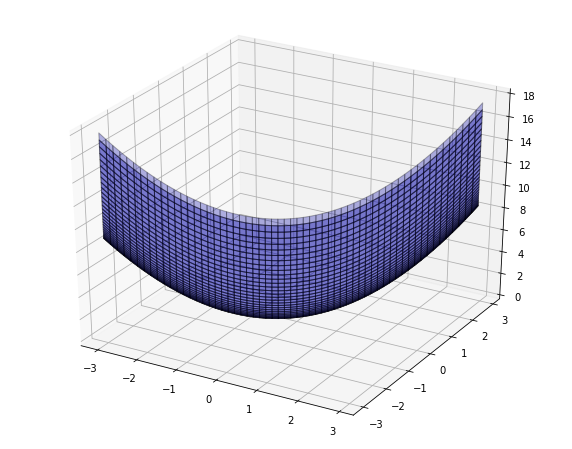

In [143]:
from mpl_toolkits.mplot3d import Axes3D

x1 = np.arange(-3,3,0.1)
x2 = np.arange(-3,3,0.1)
length1 = len(x1)
length2 = len(x2)
y = np.zeros((length1, length2))

for i in range(length1):
    for j in range(length2):
            y[i,j] = x1[i]**2 + x2[j]**2

for i in range(length1):
    for j in range(length2):
            y[j,i] = x1[j]**2 + x2[i]**2

plt.figure(figsize=(10,8))
ax = plt.subplot(1,1,1,projection = '3d')
ax.plot_surface(x1,x2,y,rstride = 1,cstride = 1,alpha = 0.3,color = 'blue',edgecolor = 'black')
plt.show()